# 08_2_DESIGN_TargetedLibrary

<a target="_blank" href="https://colab.research.google.com/github/hiyama341/ConStrain/blob/main/colab_notebooks/08_2_DESIGN_TargetedLibrary.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [137]:
%%capture
!pip install pydna
!pip install pandas
!pip install --upgrade xlrd
!pip install constrain
!pip install venn

In [138]:
def parts_encountered(df): 
    #Iterate through the list of predictions and save new encountered parts. Stop after 180 combiantions.
    #Initialisation
    parts_encounteres = {'G8H':[],'pG8H':[], 'pCPR': [], 'CPR': [], 'Sum of parts':'', 'Predictions': ''}
    sum_of_parts = 0
    i = 0
    g8h_count = 0
    cpr_count = 0
    pg8h_count = 0
    pcpr_count = 0

    #Loop through the predctions and save new parts. 
    while sum_of_parts < 140:
        sum_of_parts =  g8h_count*cpr_count*pg8h_count*pcpr_count

        parts_encounteres['Sum of parts'] = str(sum_of_parts)
        parts_encounteres['Predictions'] = str(i)
        g8h = df.G8H[i]
        pg8h = df.pG8H[i]
        cpr = df.CPR[i]
        pcpr = df.pCPR[i]
        old_sum = copy.copy(sum_of_parts)
        if g8h not in parts_encounteres['G8H']:
            parts_encounteres['G8H'].append(g8h)
            g8h_count += 1
        if pg8h not in parts_encounteres['pG8H']:
            parts_encounteres['pG8H'].append(pg8h)
            pg8h_count += 1
        if cpr not in parts_encounteres['CPR']:
            parts_encounteres['CPR'].append(cpr)
            cpr_count += 1
        if pcpr not in parts_encounteres['pCPR']:
            parts_encounteres['pCPR'].append(pcpr)
            pcpr_count += 1
        
        #sum_of_parts =  g8h_count*cpr_count*pg8h_count*pcpr_count
        i += 1

    return parts_encounteres

In [139]:
import IPython.core.display
import pathlib
import itertools
import numpy as np
import pandas as pd
import copy
import pydna
import pydna.editor
import pydna.primer
import pydna.dseqrecord
import pydna.amplify
import pydna.assembly
import pydna.gel
import pydna.ladders
from pydna.dseqrecord import Dseqrecord
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import venn

In [140]:
!git clone https://github.com/hiyama341/ConStrain_on_google_colab.git

fatal: destination path 'ConStrain_on_google_colab' already exists and is not an empty directory.


# 1. Debottlenecking the strictosidine module

## Hypothesis
1. Specific combinations of CPR / G8H homologs and corresponding expression levels can remove the G8H bottleneck in the Strictosidine pathway

### Aim: To test the hypothesis through library design

Tasks
1. analyse seq data from first library construction
2. **2nd Library**
    - investigate parts already in the lab
    - create parts missing
    - pool together parts
    - transformation
4. Phenotyping
5. Data analysis

# 2. Intro

The purpose of this notebook is to create a smaller library based on a machine learning prediction of the highest producing combination of genes from combinations seen in the figure below. 

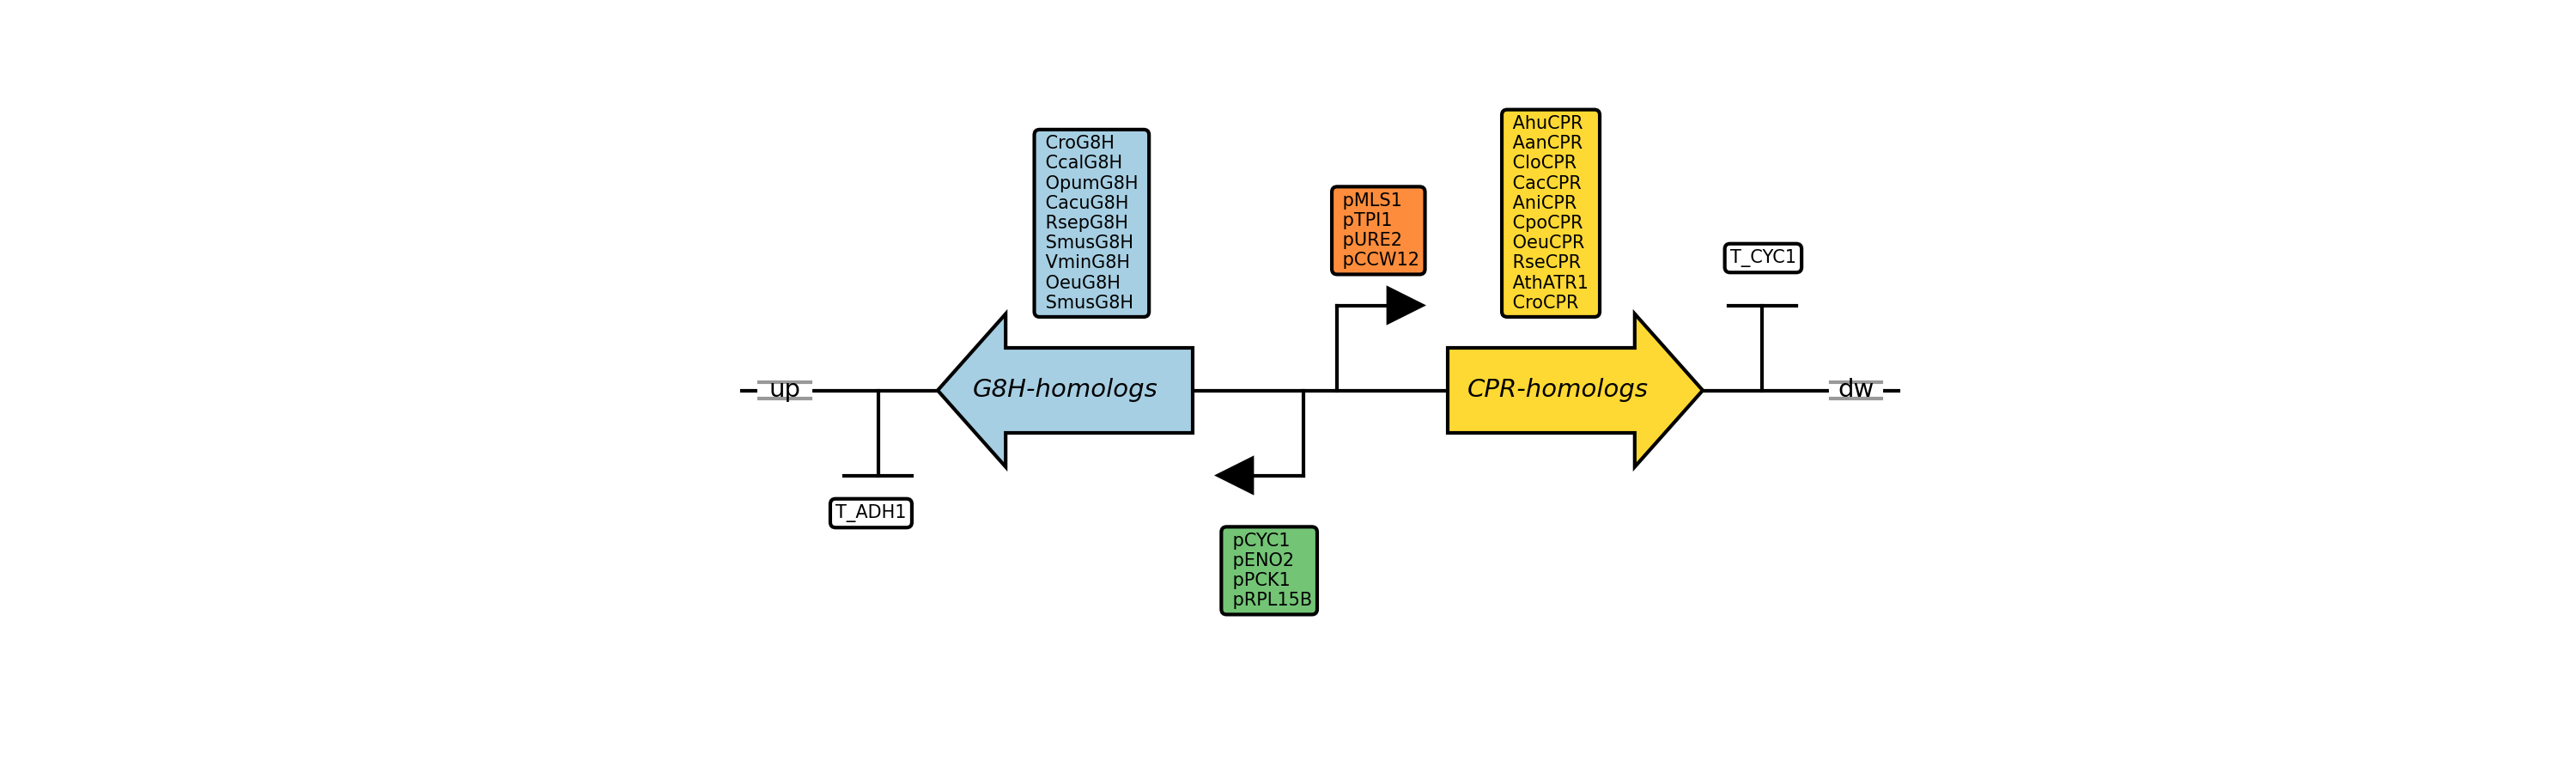

In [141]:
IPython.core.display.Image('ConStrain_on_google_colab/pictures/Genetic construct w dnaplotlib.png', width=2000)

The figure above illustrates the original library design.



**Machine learning pred:**
- In the following, the machine learning outcome can be found. It was found that 140 strains (5x2x2x7)was suitable for the pupose.
- From the predictions, the following genes have been selected: 
    - Smus, Vmin, Cro, Rsep, Oeu
    - pCYC1, pENO2
    - Clo, Ara, Rse, Aan, Cro, Ani, Ahu
    - pTPI1, pCCW12

**Experiment:**
- To perform this experiment, a total of 35 (5*7) transformation should be performed 
- To perform this, each gene has several different overhangs and these are pooled together. All promoters are also pooled together. UP, DW and cTRP1 is pooled together. Then the correct mixes should be performed. 

The previous experiments were simulated in [05_1_BUILD_CombinatorialLibrary_AllStrains](05_1_BUILD_CombinatorialLibrary_AllStrains.ipynb), and the next step in the process was investigation of the machine learning outcome.

## 3.1 Getting parts based on MAE

In [142]:
#Get prediction data
# first iteration OF ML
df = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/all_predictions/first_round/Predicted_strict_named_CMP_MAE.csv')

# SECOND_iteration_of_ml
df2 = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/all_predictions/first_round/top_ML_predicted_after_first_DBTL_merged_analytics.csv')

list_of_dfs = [df, df2]

In [143]:
df

,G8H,pG8H,pCPR,CPR,predict
0,Cro,ENO2,TPI1,Ara,154
1,Cro,ENO2,TPI1,Clo,152
2,Smus,ENO2,TPI1,Aan,129
3,Smus,ENO2,CCW12,Clo,125
4,Cro,ENO2,TPI1,Rse,123
...,...,...,...,...,...
1133,Cacu,ENO2,MLS1,Cro,-3
1134,Cacu,ENO2,MLS1,Clo,-4
1135,Cacu,ENO2,MLS1,Ahu,-4
1136,Cacu,ENO2,MLS1,Ani,-4


In [144]:
df2

,G8H,pG8H,pCPR,CPR,Predicted_strict_production
0,Smus,ENO2,TPI1,Cro,226.138557
1,Smus,ENO2,TPI1,Clo,210.261962
2,Smus,ENO2,TPI1,Cac,205.359575
3,Smus,ENO2,TPI1,Aan,204.539731
4,Rsep,ENO2,TPI1,Cro,193.218189
...,...,...,...,...,...
1116,Rsep,PCK1,CCW12,Rse,-2.813507
1117,Ccal,PCK1,TPI1,Ara,-3.103402
1118,Cro,PCK1,TPI1,Ani,-3.587722
1119,Vmin,PCK1,TPI1,Ani,-3.955426


Parts distribution - bar chart

In [145]:
list_of_analysis = ['1st_ana', '2nd_ana']

In [146]:
for i in range(len(list_of_dfs)): 
    parts = parts_encountered(list_of_dfs[i])
    print('\n')
    print(f"{i} : {list_of_analysis[i]}")
    for k,v in parts.items(): 
        print(k,v)



0 : 1st_ana
G8H ['Cro', 'Smus', 'Rsep', 'Opum', 'Vmin']
pG8H ['ENO2', 'CYC1']
pCPR ['TPI1', 'CCW12']
CPR ['Ara', 'Clo', 'Aan', 'Rse', 'Cro', 'Cac', 'Oeu']
Sum of parts 140
Predictions 35


1 : 2nd_ana
G8H ['Smus', 'Rsep', 'Oeu', 'Vmin', 'Cro']
pG8H ['ENO2', 'CYC1']
pCPR ['TPI1', 'CCW12']
CPR ['Cro', 'Clo', 'Cac', 'Aan', 'Ara', 'Rse', 'Oeu']
Sum of parts 140
Predictions 26


### Selecting colors

In [147]:
from constrain.plotting.plotting import color_range_dict
# importing a range of colors
cpr_color = color_range_dict()['yellow'][::2][::-1]
print(len(cpr_color))
pcpr_color = color_range_dict()['orange'][::6][::-1]
print(len(pcpr_color))
g8h_color= color_range_dict()['blue'][::3][::-1]
print(len(g8h_color))
pg8h_color = color_range_dict()['green'][::5][::-1]
print(len(pg8h_color))

10
4
8
4


In [148]:
g8h_list_of_index = ["Cacu_G8H", "Opum_G8H","Cro_G8H","Vmin_G8H","Smus_G8H","Rsep_G8H","Oeu_G8H","Ccal_G8H"]
cpr_list_of_index = ["Cro_CPR", "Aan_CPR","Ara_CPR","Clo_CPR","Rse_CPR","Ahu_CPR","Ani_CPR","Cac_CPR","Oeu_CPR","Cpo_CPR"]
pg8h_list_of_index = ["CYC1", "ENO2","PCK1","RPL15B"]
pcpr_list_of_index = ["CCW12", "TPI1","MLS1","URE2"]

In [149]:
G8H_color_codes = dict(zip(g8h_list_of_index, g8h_color))
pG8H_color_codes = dict(zip(pg8h_list_of_index, pg8h_color))
pCPR_color_codes = dict(zip(pcpr_list_of_index, pcpr_color))
CPR_color_codes = dict(zip(cpr_list_of_index, cpr_color))

In [150]:
colorDict = dict(G8H_color_codes, **pG8H_color_codes,**pCPR_color_codes, **CPR_color_codes)

## Venn diagram

In [152]:
parts_1st_ml = parts_encountered(df)
parts_2nd_ml = parts_encountered(df2)

for k,v in parts_1st_ml.items(): 
    parts_1st_ml[k] = set(parts_1st_ml[k])
    
for k,v in parts_2nd_ml.items(): 
    parts_2nd_ml[k] = set(parts_2nd_ml[k])
parts_2nd_ml

{'G8H': {'Cro', 'Oeu', 'Rsep', 'Smus', 'Vmin'},
 'pG8H': {'CYC1', 'ENO2'},
 'pCPR': {'CCW12', 'TPI1'},
 'CPR': {'Aan', 'Ara', 'Cac', 'Clo', 'Cro', 'Oeu', 'Rse'},
 'Sum of parts': {'0', '1', '4'},
 'Predictions': {'2', '6'}}

In [153]:
# remove sum of parts 
parts_1st_ml.pop('Sum of parts', None)
parts_2nd_ml.pop('Sum of parts', None)

{'0', '1', '4'}

In [154]:
#Remove predictions
parts_1st_ml.pop('Predictions', None)
parts_2nd_ml.pop('Predictions', None)

{'2', '6'}

In [155]:
from venn import venn
%matplotlib inline
venn_dicts = []

for k, v in parts_1st_ml.items(): 
    for k1, v1 in parts_2nd_ml.items():
        if k==k1:
            my_dict = {k+'_ML1':v, k1+'_ML2':v1}
            venn_dicts.append(my_dict)
            print(my_dict)
            #venn(my_dict)
            #venn_diagrams.append(venn(my_dict))

{'G8H_ML1': {'Cro', 'Rsep', 'Smus', 'Opum', 'Vmin'}, 'G8H_ML2': {'Cro', 'Oeu', 'Rsep', 'Smus', 'Vmin'}}
{'pG8H_ML1': {'CYC1', 'ENO2'}, 'pG8H_ML2': {'CYC1', 'ENO2'}}
{'pCPR_ML1': {'TPI1', 'CCW12'}, 'pCPR_ML2': {'TPI1', 'CCW12'}}
{'CPR_ML1': {'Cro', 'Oeu', 'Ara', 'Cac', 'Aan', 'Clo', 'Rse'}, 'CPR_ML2': {'Cro', 'Oeu', 'Ara', 'Cac', 'Aan', 'Clo', 'Rse'}}


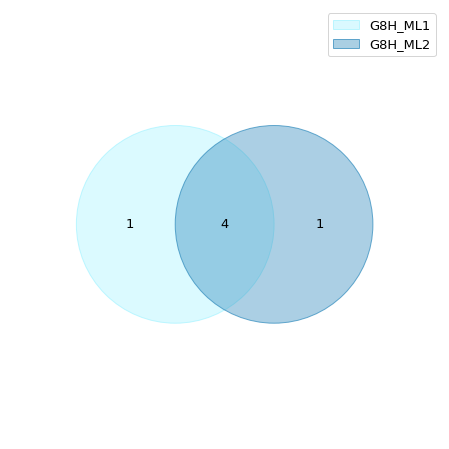

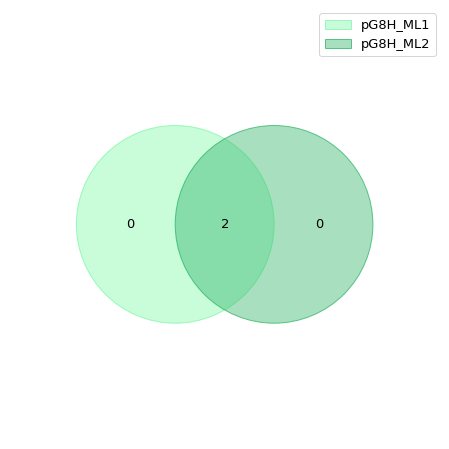

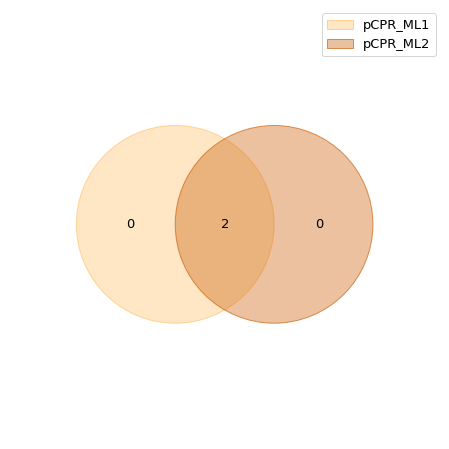

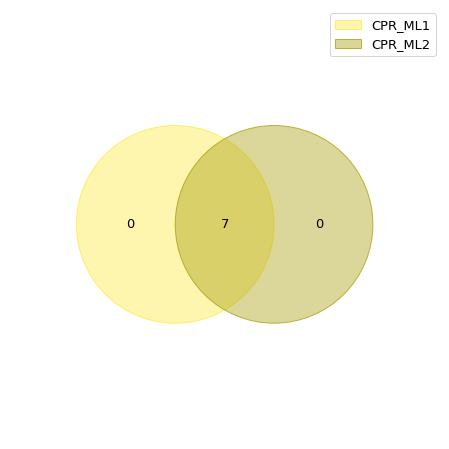

In [156]:
# G8H
venn(venn_dicts[0], cmap = [g8h_color[0], g8h_color[-1] ])
name = 'Venn_G8H'
plt.savefig('ConStrain_on_google_colab/data/10-plots/08_2_DESIGN_Targeted_library/'+name+'.pdf',format = 'pdf',  dpi = 120)


# pG8H
venn(venn_dicts[1], cmap = [pg8h_color[0], pg8h_color[-1] ])
name = 'Venn_pG8H'
plt.savefig('ConStrain_on_google_colab/data/10-plots/08_2_DESIGN_Targeted_library/'+name+'.pdf',format = 'pdf',  dpi = 120)


# pCPR
venn(venn_dicts[2], cmap = [pcpr_color[0], pcpr_color[-1] ])
name = 'Venn_pCPR'
plt.savefig('ConStrain_on_google_colab/data/10-plots/08_2_DESIGN_Targeted_library/'+name+'.pdf',format = 'pdf',  dpi = 120)


# CPR
venn(venn_dicts[3], cmap = [cpr_color[1], cpr_color[-1] ])
name = 'Venn_CPR'
plt.savefig('ConStrain_on_google_colab/data/10-plots/08_2_DESIGN_Targeted_library/'+name+'.pdf',format = 'pdf',  dpi = 120)

## Stacked barplot of top predicted combinations from the combinatorial library

In [116]:
# take the columns we are interested in
def_merged = df2[['G8H', 'pG8H','pCPR','CPR']]
def_merged['G8H'] = def_merged['G8H']+'_G8H'
def_merged['CPR'] = def_merged['CPR']+'_CPR'
def_merged['Index'] = def_merged.index
def_merged.head()

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_5956/67215768.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def_merged['G8H'] = def_merged['G8H']+'_G8H'
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_5956/67215768.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def_merged['CPR'] = def_merged['CPR']+'_CPR'


,G8H,pG8H,pCPR,CPR,Index
0,Smus_G8H,ENO2,TPI1,Cro_CPR,0
1,Smus_G8H,ENO2,TPI1,Clo_CPR,1
2,Smus_G8H,ENO2,TPI1,Cac_CPR,2
3,Smus_G8H,ENO2,TPI1,Aan_CPR,3
4,Rsep_G8H,ENO2,TPI1,Cro_CPR,4


In [117]:
list_of_parts = []
parst_index = []

for index, row in def_merged.iterrows():
    list_of_parts.append(row['G8H'])
    list_of_parts.append(row['pG8H'])
    list_of_parts.append(row['pCPR'])
    list_of_parts.append(row['CPR'])
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)


distribution = [25]*len(parst_index)
print(len(list_of_parts))
print(len(parst_index))
print(len(distribution))

4484
4484
4484


In [118]:
d = {'Index':parst_index,'Part':list_of_parts, 'Distribution':distribution }
df2 = pd.DataFrame(d)

Slicing the dataframe

In [119]:
df100 = df2[:400]

In [120]:
# making a cross tab pd.dataframe
cross_tab_prop = pd.crosstab(index=df100['Index'],
                             columns=df100['Part'])
cross_tab_prop

Part,Aan_CPR,Ara_CPR,CCW12,CYC1,Cac_CPR,Clo_CPR,Cpo_CPR,Cro_CPR,Cro_G8H,ENO2,Oeu_CPR,Oeu_G8H,Opum_G8H,RPL15B,Rse_CPR,Rsep_G8H,Smus_G8H,TPI1,URE2,Vmin_G8H
Index,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0
1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0
2,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0
3,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0
4,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0
96,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
97,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0


In [121]:
coloumns = list(cross_tab_prop.columns)
coloumns

['Aan_CPR',
 'Ara_CPR',
 'CCW12',
 'CYC1',
 'Cac_CPR',
 'Clo_CPR',
 'Cpo_CPR',
 'Cro_CPR',
 'Cro_G8H',
 'ENO2',
 'Oeu_CPR',
 'Oeu_G8H',
 'Opum_G8H',
 'RPL15B',
 'Rse_CPR',
 'Rsep_G8H',
 'Smus_G8H',
 'TPI1',
 'URE2',
 'Vmin_G8H']

In [122]:
all_parts = ['Cacu_G8H',
 'Opum_G8H',
 'Cro_G8H',
 'Vmin_G8H',
 'Smus_G8H',
 'Rsep_G8H',
 'Oeu_G8H',
 'Ccal_G8H',
 'CYC1',
 'ENO2',
 'PCK1',
 'RPL15B',
 'CCW12',
 'TPI1',
 'MLS1',
 'URE2',    
 'Cro_CPR',
 'Aan_CPR',
 'Ara_CPR',
 'Clo_CPR',
 'Rse_CPR',
 'Ahu_CPR',
 'Ani_CPR',
 'Cac_CPR',
 'Oeu_CPR',
 'Cpo_CPR']

Check what names there are in the columns

In [123]:
fixed_columns = []
for name in all_parts: 
    if name in coloumns: 
        fixed_columns.append(name)
fixed_columns

cross_tab_prop = cross_tab_prop[fixed_columns]

In [124]:
print(cross_tab_prop.columns)
cross_tab_prop

Index(['Opum_G8H', 'Cro_G8H', 'Vmin_G8H', 'Smus_G8H', 'Rsep_G8H', 'Oeu_G8H',
       'CYC1', 'ENO2', 'RPL15B', 'CCW12', 'TPI1', 'URE2', 'Cro_CPR', 'Aan_CPR',
       'Ara_CPR', 'Clo_CPR', 'Rse_CPR', 'Cac_CPR', 'Oeu_CPR', 'Cpo_CPR'],
      dtype='object', name='Part')


Part,Opum_G8H,Cro_G8H,Vmin_G8H,Smus_G8H,Rsep_G8H,Oeu_G8H,CYC1,ENO2,RPL15B,CCW12,TPI1,URE2,Cro_CPR,Aan_CPR,Ara_CPR,Clo_CPR,Rse_CPR,Cac_CPR,Oeu_CPR,Cpo_CPR
Index,,,,,,,,,,,,,,,,,,,,
0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0
96,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0
97,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0


In [125]:
from constrain.plotting.plotting import carpet_barplot

### Plotting best 100 combinations

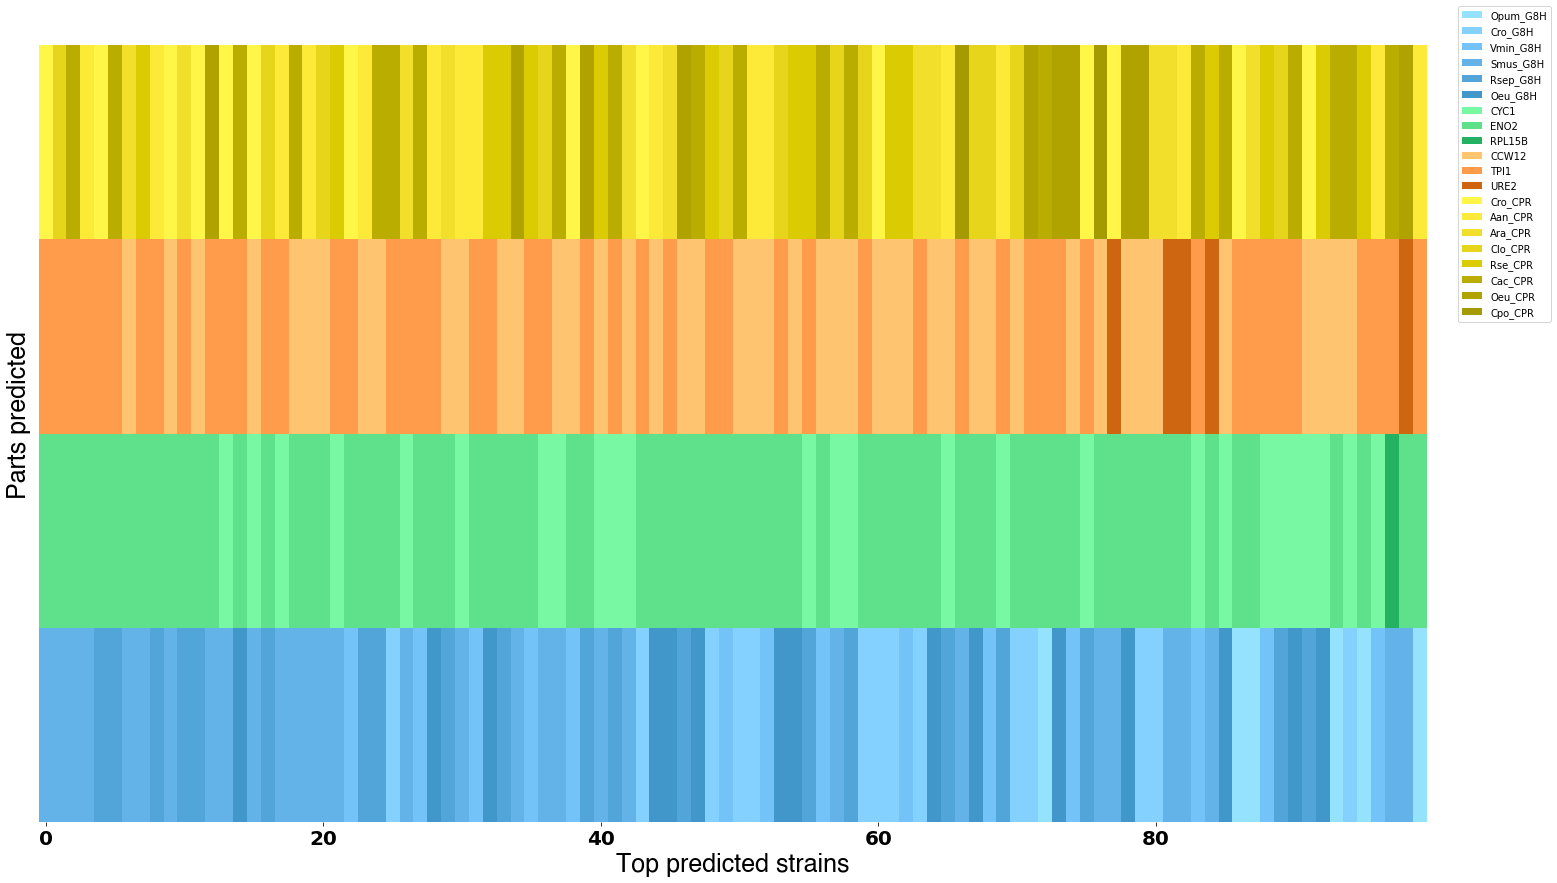

In [126]:
name = 'Best_combinations_predicted_by_the_ML_'
carpet_barplot(cross_tab_prop, colorDict, save_pdf= True , path ='ConStrain_on_google_colab/data/10-plots/08_2_DESIGN_Targeted_library/'+name, xlabel ='Top predicted strains' , ylabel = 'Parts predicted' )

### best 200 predicted combinations

200


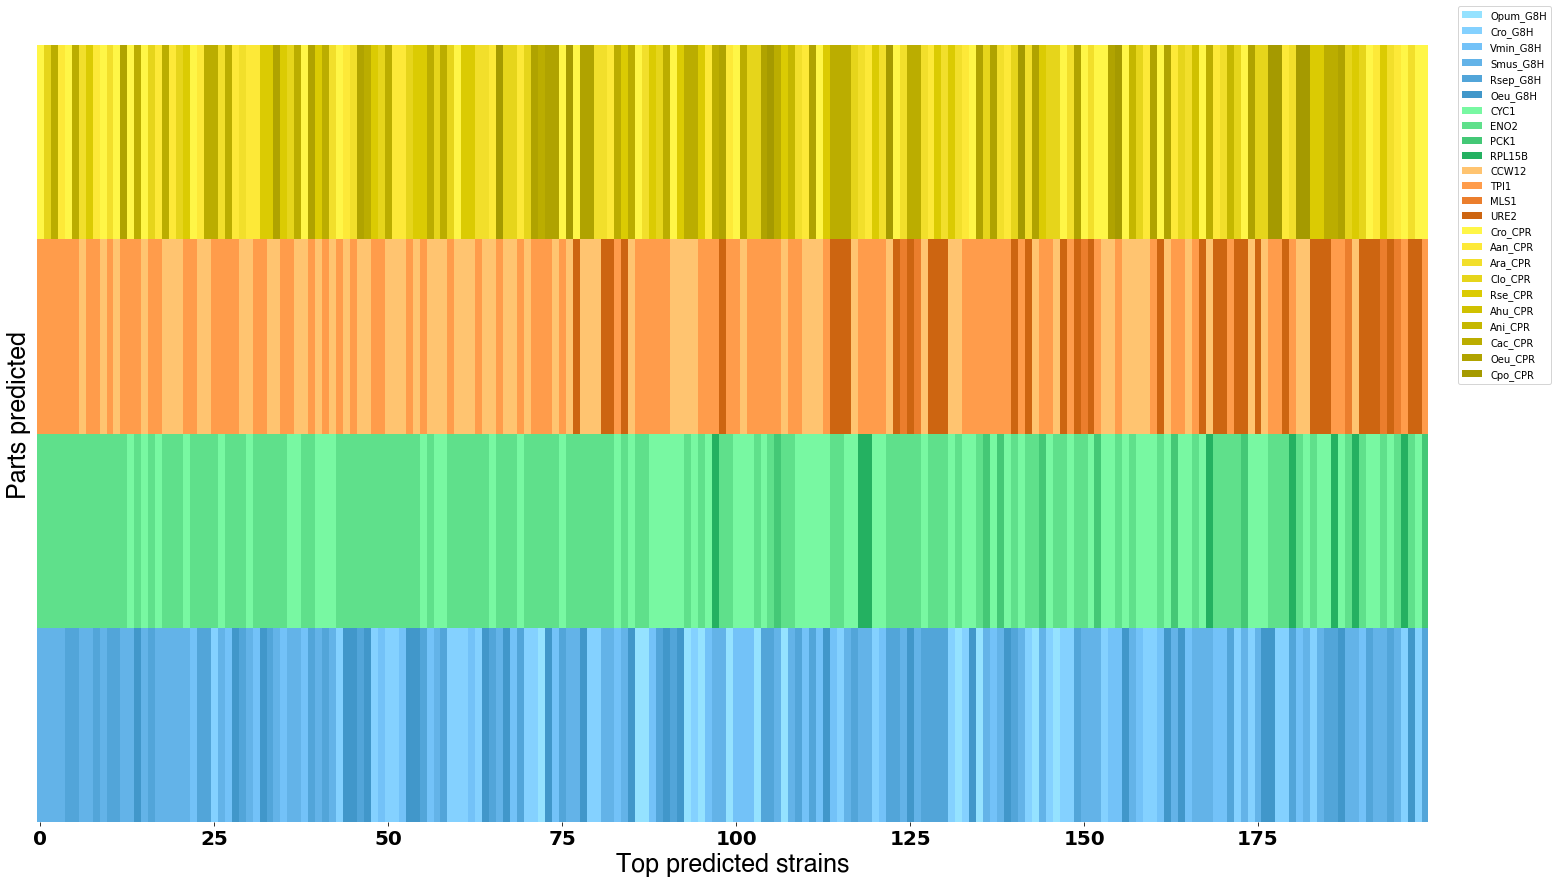

In [127]:
# slice df
df200 = df2[:800]
cross_tab_prop = pd.crosstab(index=df200['Index'],
                             columns=df200['Part'])

print(len(cross_tab_prop))
# fix coloumns
coloumns = list(cross_tab_prop.columns)
fixed_columns = []
for name in all_parts:     
    if name in coloumns: 
        fixed_columns.append(name)

# get only the columns we use
cross_tab_prop = cross_tab_prop[fixed_columns]


name = 'Best_combinations_predicted_by_the_ML_200_1'
carpet_barplot(cross_tab_prop, colorDict, save_pdf= True , path ='ConStrain_on_google_colab/data/10-plots/08_2_DESIGN_Targeted_library/'+name, xlabel ='Top predicted strains' , ylabel = 'Parts predicted' ) 

### best 400 predicted combinations

400


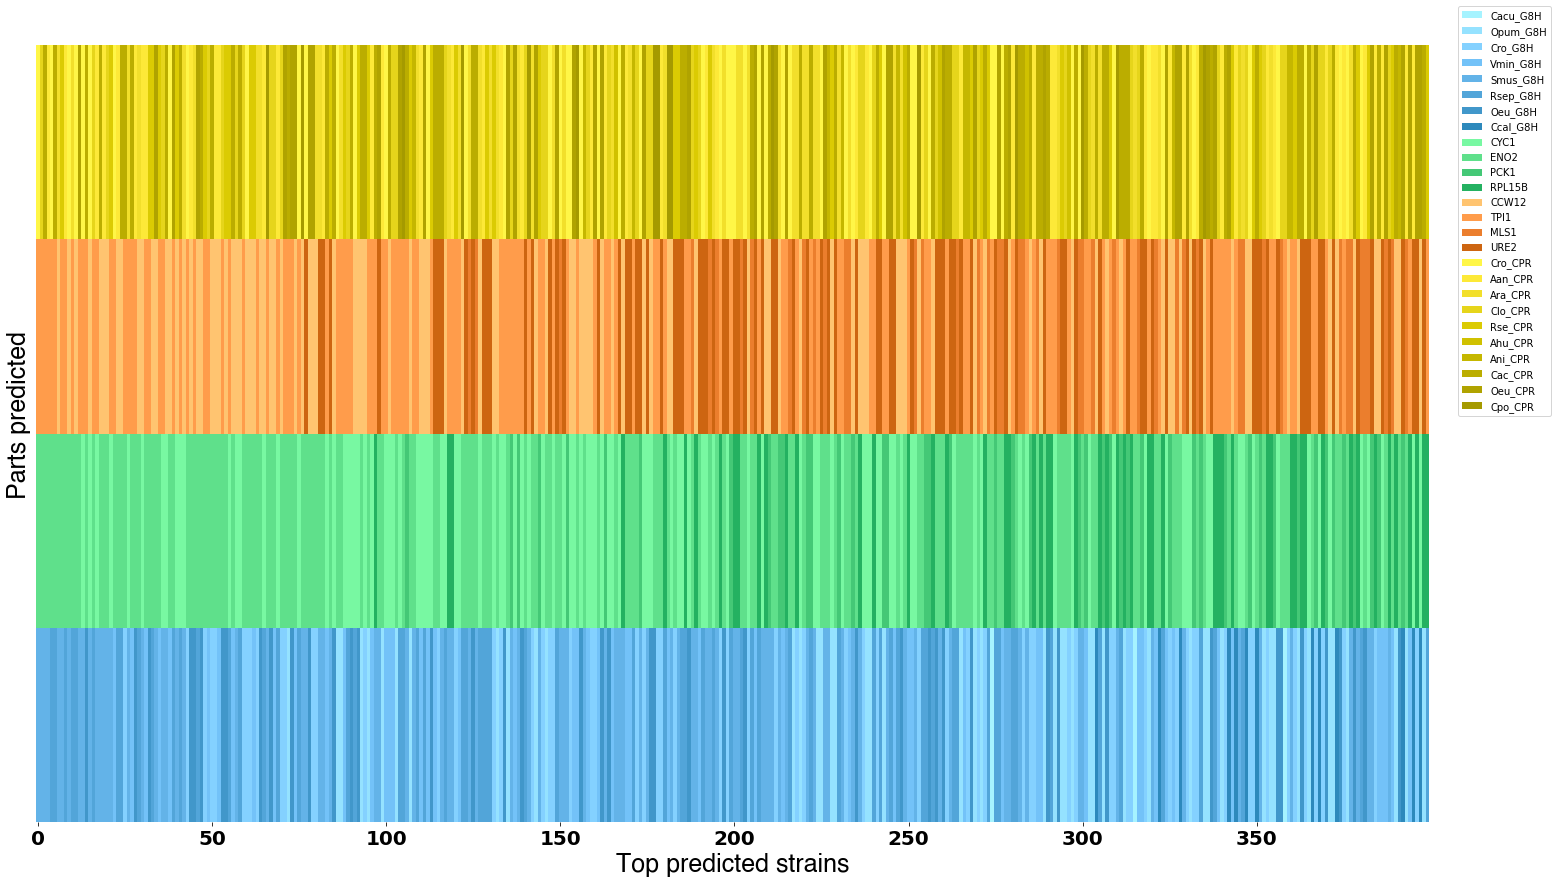

In [128]:
# slice df
df200 = df2[:1600]
cross_tab_prop = pd.crosstab(index=df200['Index'],
                             columns=df200['Part'])

print(len(cross_tab_prop))
# fix coloumns
coloumns = list(cross_tab_prop.columns)
fixed_columns = []
for name in all_parts:     
    if name in coloumns: 
        fixed_columns.append(name)

# get only the columns we use
cross_tab_prop = cross_tab_prop[fixed_columns]


name = 'Best_combinations_predicted_by_the_ML_400_1'
carpet_barplot(cross_tab_prop, colorDict, save_pdf= True , path ='ConStrain_on_google_colab/data/10-plots/08_2_DESIGN_Targeted_library/'+name, xlabel ='Top predicted strains' , ylabel = 'Parts predicted' )

### Best of all 1121 combinations

1121


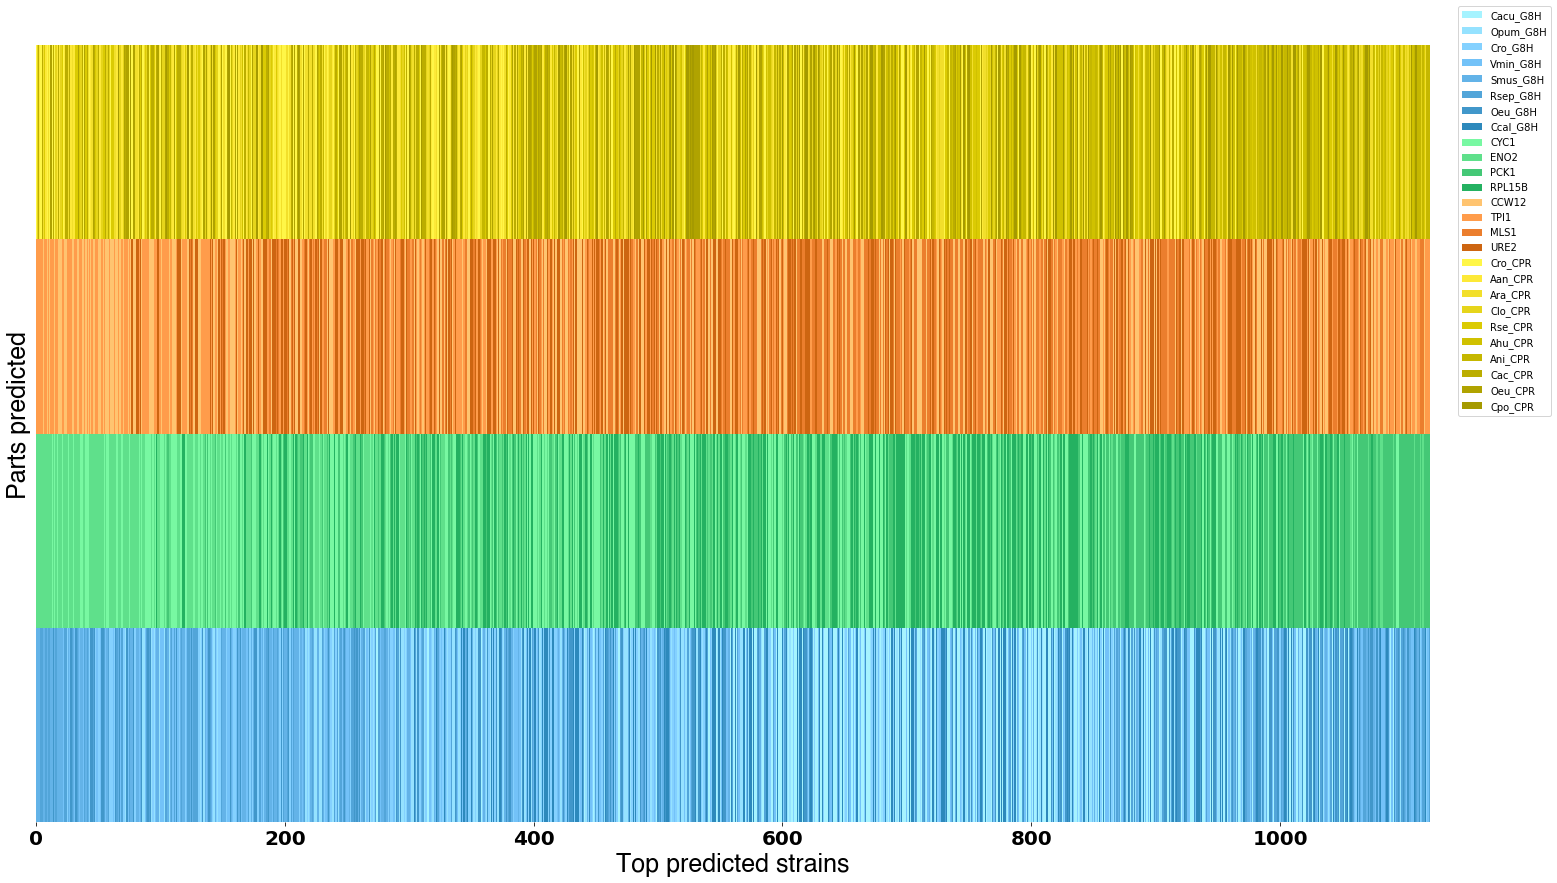

In [129]:
# slice df
df200 = df2[:]
cross_tab_prop = pd.crosstab(index=df200['Index'],
                             columns=df200['Part'])
print(len(cross_tab_prop))
# fix coloumns
coloumns = list(cross_tab_prop.columns)
fixed_columns = []
for name in all_parts:     
    if name in coloumns: 
        fixed_columns.append(name)

# get only the columns we use
cross_tab_prop = cross_tab_prop[fixed_columns]


name = 'Best_combinations_predicted_by_the_ML_all'
carpet_barplot(cross_tab_prop, colorDict, save_pdf= True , path ='ConStrain_on_google_colab/data/10-plots/08_2_DESIGN_Targeted_library/'+name, xlabel ='Top predicted strains' , ylabel = 'Parts predicted'  )

### The best combinations for max 180 strains i.e 35 predictions - DF1 (first ml)

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_5956/1640422211.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def_merged['G8H'] = def_merged['G8H']+'_G8H'
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_5956/1640422211.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def_merged['CPR'] = def_merged['CPR']+'_CPR'


4552
4552
4552


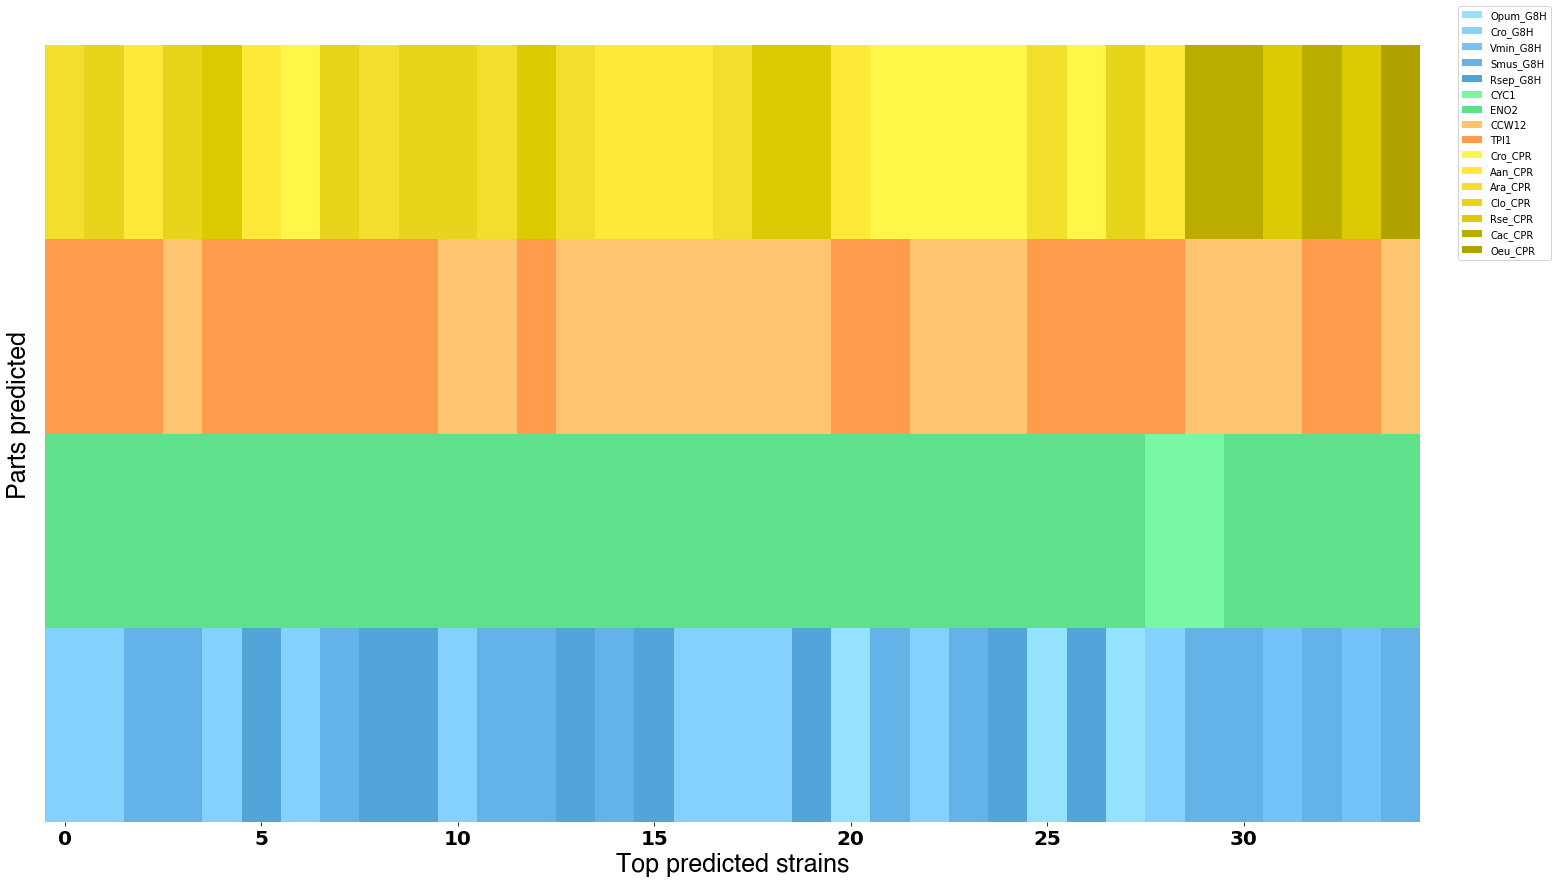

In [132]:
# take the columns we are interested in
def_merged = df[['G8H', 'pG8H','pCPR','CPR']]
def_merged['G8H'] = def_merged['G8H']+'_G8H'
def_merged['CPR'] = def_merged['CPR']+'_CPR'
def_merged['Index'] = def_merged.index

list_of_parts = []
parst_index = []

for index, row in def_merged.iterrows():
    list_of_parts.append(row['G8H'])
    list_of_parts.append(row['pG8H'])
    list_of_parts.append(row['pCPR'])
    list_of_parts.append(row['CPR'])
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)

distribution = [25]*len(parst_index)
print(len(list_of_parts))
print(len(parst_index))
print(len(distribution))

# make a df
d = {'Index':parst_index,'Part':list_of_parts, 'Distribution':distribution }
df_1 = pd.DataFrame(d)
tot_predictions = 35*4
df_35 = df_1[:tot_predictions]


# making a cross tab pd.dataframe
cross_tab_prop = pd.crosstab(index=df_35['Index'],
                             columns=df_35['Part'])
# get the right coloums
coloumns = list(cross_tab_prop.columns)
all_parts = ['Cacu_G8H',
 'Opum_G8H',
 'Cro_G8H',
 'Vmin_G8H',
 'Smus_G8H',
 'Rsep_G8H',
 'Oeu_G8H',
 'Ccal_G8H',
 'CYC1',
 'ENO2',
 'PCK1',
 'RPL15B',
 'CCW12',
 'TPI1',
 'MLS1',
 'URE2',    
 'Cro_CPR',
 'Aan_CPR',
 'Ara_CPR',
 'Clo_CPR',
 'Rse_CPR',
 'Ahu_CPR',
 'Ani_CPR',
 'Cac_CPR',
 'Oeu_CPR']


# fix columns
fixed_columns = []
for name in all_parts: 
    if name in coloumns: 
        fixed_columns.append(name)
fixed_columns

cross_tab_prop = cross_tab_prop[fixed_columns]

# carpet plot
name = 'Best_combinations_predicted_by_the_ML_35_1'
carpet_barplot(cross_tab_prop, colorDict, save_pdf= True , path ='ConStrain_on_google_colab/data/10-plots/08_2_DESIGN_Targeted_library/'+name, xlabel ='Top predicted strains' , ylabel = 'Parts predicted' ) 

### The best combinations for max 180 strains i.e 26 predictions - DF2 (second ml)

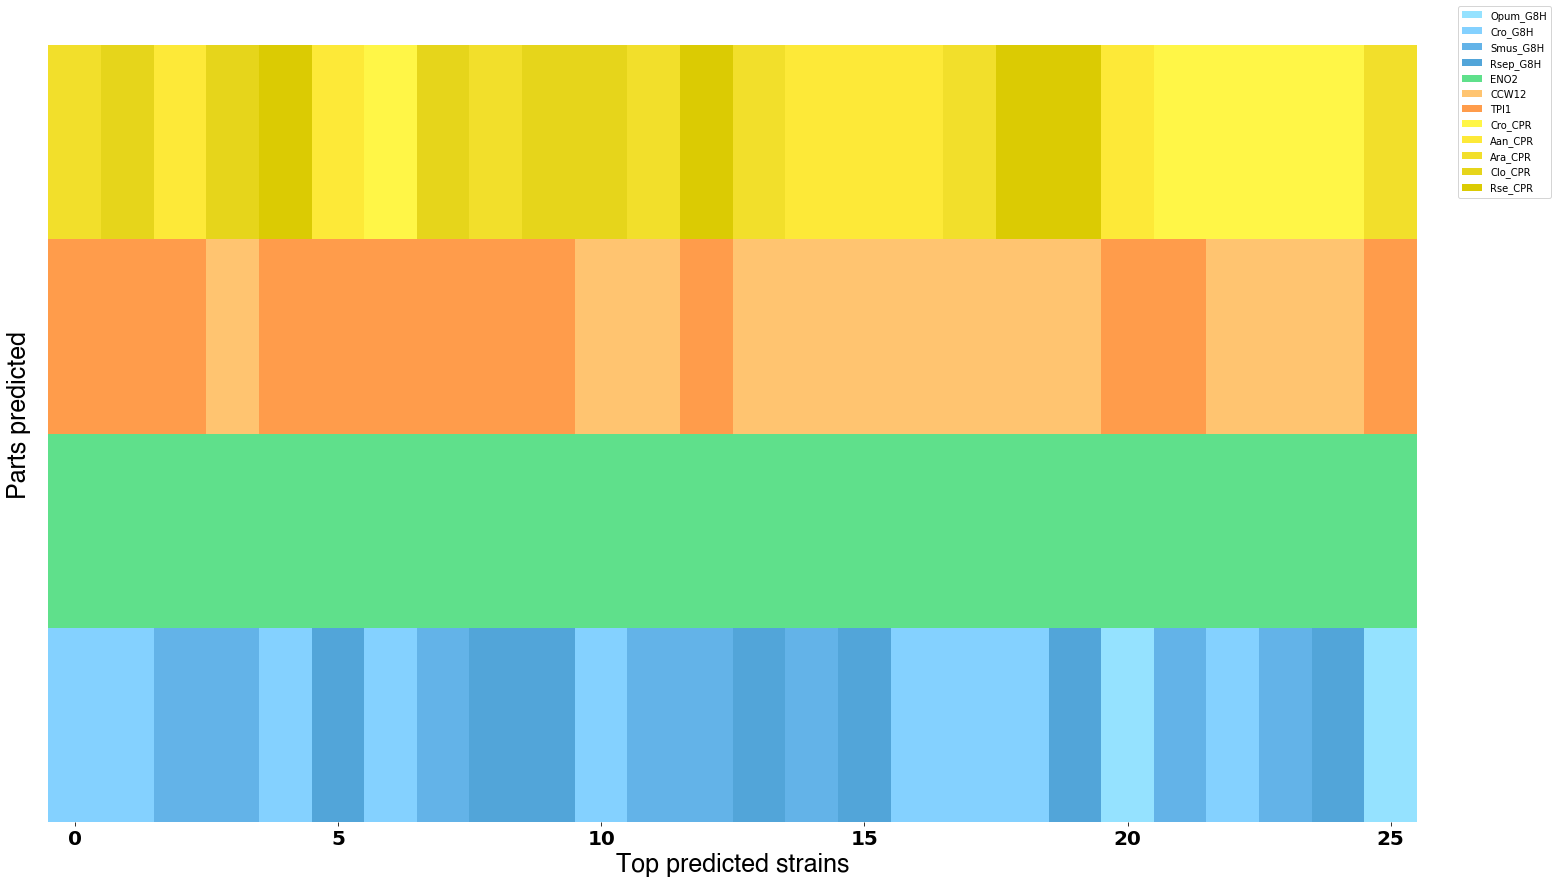

In [135]:
# Make a dataframe with top26 predictio s
tot_combinations_from_predictions = 26*4
df26 = df2[:tot_combinations_from_predictions]

# Make a crosstab df
cross_tab_prop = pd.crosstab(index=df26['Index'],
                             columns=df26['Part'])

# fix coloumns
coloumns = list(cross_tab_prop.columns)
fixed_columns = []
for name in all_parts:     
    if name in coloumns: 
        fixed_columns.append(name)
fixed_columns

# get only the columns we use
cross_tab_prop = cross_tab_prop[fixed_columns]

# use the carpet plot function
name = 'Best_combinations_predicted_by_the_ML_26_1'
carpet_barplot(cross_tab_prop, colorDict, save_pdf= True , path ='ConStrain_on_google_colab/data/10-plots/08_2_DESIGN_Targeted_library/'+name, xlabel ='Top predicted strains' , ylabel = 'Parts predicted' ) 

### Parts distribution of the sampled strains

In [37]:
parts_sampled_strains = pd.read_csv('ConStrain_on_google_colab/data/07-lcms/processed/lcms_data/with_genotypes/genotypes_1st_round_w_wo_full_genotype.csv')
parts_sampled_strains = parts_sampled_strains[['Line_name','Amt_norm_x', 'G8H','pG8H', 'pCPR', 'CPR', ]]
parts_sampled_strains

,Line_name,Amt_norm_x,G8H,pG8H,pCPR,CPR
0,yp50_D03,245.034275,SmusG8H,pENO2,pTPI1,AraCPR
1,yp50_G03,156.327285,RsepG8H,pENO2,pTPI1,RseCPR
2,yp50_E05,144.340857,SmusG8H,pCYC1,pTPI1,CacCPR
3,yp51_A02,135.693498,OeuG8H,pENO2,pTPI1,CroCPR
4,yp50_A09,134.321746,VminG8H,pENO2,pTPI1,AraCPR
...,...,...,...,...,...,...
233,yp49_B09,0.000000,NaN,NaN,NaN,NaN
234,yp51_E06,0.000000,NaN,NaN,NaN,NaN
235,yp51_E03,0.000000,NaN,NaN,NaN,NaN
236,yp50_D10,0.000000,NaN,NaN,NaN,NaN


In [38]:
list_of_parts = []
parst_index = []

for index, row in parts_sampled_strains.iterrows():
    list_of_parts.append(row['G8H'])
    list_of_parts.append(row['pG8H'])
    list_of_parts.append(row['pCPR'])
    list_of_parts.append(row['CPR'])
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)

distribution = [25]*len(parst_index)
print(len(list_of_parts))
print(len(parst_index))
print(len(distribution))

952
952
952


In [39]:
d = {'Index':parst_index,'Part':list_of_parts, 'Distribution':distribution }
df2 = pd.DataFrame(d)

In [40]:
df2 = df2.replace(np.nan, 'Not_fully_genotyped')

In [41]:
pd.set_option('display.max_columns', None)

In [42]:
cross_tab_prop = pd.crosstab(index=df2['Index'],
                             columns=df2['Part'])
cross_tab_prop

Part,AanCPR,AhuCPR,AniCPR,AraCPR,CacCPR,CacuG8H,CcalG8H,CloCPR,CpoCPR,CroCPR,CroG8H,Not_fully_genotyped,OeuCPR,OeuG8H,OpumG8H,RseCPR,RsepG8H,SmusG8H,VminG8H,pCCW12,pCYC1,pENO2,pMLS1,pPCK1,pRPL15B,pTPI1,pURE2
Index,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
234,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
235,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [52]:
coloumns = list(cross_tab_prop.columns)

Have to make a new colorDict since the names in this data is different

In [44]:
g8h_list_of_index = ["CacuG8H", "OpumG8H","CroG8H","VminG8H","SmusG8H","RsepG8H","OeuG8H","CcalG8H"]
cpr_list_of_index = ["CroCPR", "AanCPR","AraCPR","CloCPR","RseCPR","AhuCPR","AniCPR","CacCPR","OeuCPR","CpoCPR"]
pg8h_list_of_index = ["pCYC1", "pENO2","pPCK1","pRPL15B"]
pcpr_list_of_index = ["pCCW12", "pTPI1","pMLS1","pURE2"]
NaN_list_of_index = ["Not_fully_genotyped"]

all_parts = g8h_list_of_index +cpr_list_of_index+ pg8h_list_of_index+pcpr_list_of_index+ NaN_list_of_index

In [45]:
G8H_color_codes = dict(zip(g8h_list_of_index, g8h_color))
pG8H_color_codes = dict(zip(pg8h_list_of_index, pg8h_color))
pCPR_color_codes = dict(zip(pcpr_list_of_index, pcpr_color))
CPR_color_codes = dict(zip(cpr_list_of_index, cpr_color))

In [46]:
G8H_color_codes = dict(zip(g8h_list_of_index, g8h_color))
pG8H_color_codes = dict(zip(pg8h_list_of_index, pg8h_color))
pCPR_color_codes = dict(zip(pcpr_list_of_index, pcpr_color))
CPR_color_codes = dict(zip(cpr_list_of_index, cpr_color))

In [47]:
colorDict = dict(G8H_color_codes, **pG8H_color_codes,**pCPR_color_codes, **CPR_color_codes)
colorDict

{'CacuG8H': '#a6f3ff',
 'OpumG8H': '#95e2ff',
 'CroG8H': '#84d1ff',
 'VminG8H': '#73c2f8',
 'SmusG8H': '#63b3e8',
 'RsepG8H': '#52a5d9',
 'OeuG8H': '#4197ca',
 'CcalG8H': '#2d89bc',
 'pCYC1': '#78f8a2',
 'pENO2': '#5fe08b',
 'pPCK1': '#44c876',
 'pRPL15B': '#24b161',
 'pCCW12': '#ffc470',
 'pTPI1': '#ff9c4b',
 'pMLS1': '#eb7e2d',
 'pURE2': '#cd6511',
 'CroCPR': '#fff647',
 'AanCPR': '#fde938',
 'AraCPR': '#f2df2b',
 'CloCPR': '#e6d51b',
 'RseCPR': '#dbcb03',
 'AhuCPR': '#d0c100',
 'AniCPR': '#c5b700',
 'CacCPR': '#bbad00',
 'OeuCPR': '#b0a300',
 'CpoCPR': '#a59a00'}

Making the parts appear in the correct order 

In [48]:
right_order = ['CacuG8H',
 'OpumG8H',
 'CroG8H',
 'VminG8H',
 'SmusG8H',
 'RsepG8H',
 'OeuG8H',
 'CcalG8H',
 'pCYC1',
 'pENO2',
 'pPCK1',
 'pRPL15B',
 'pCCW12',
 'pTPI1',
 'pMLS1',
 'pURE2',    
 'CroCPR',
 'AanCPR',
 'AraCPR',
 'CloCPR',
 'RseCPR',
 'AhuCPR',
 'AniCPR',
 'CacCPR',
 'OeuCPR',
 'CpoCPR', 
 'Not_fully_genotyped']

In [49]:
fixed_columns = []
for name in right_order: 
    print(name)
    if name in coloumns: 
        fixed_columns.append(name)
cross_tab_prop = cross_tab_prop[fixed_columns]

CacuG8H
OpumG8H
CroG8H
VminG8H
SmusG8H
RsepG8H
OeuG8H
CcalG8H
pCYC1
pENO2
pPCK1
pRPL15B
pCCW12
pTPI1
pMLS1
pURE2
CroCPR
AanCPR
AraCPR
CloCPR
RseCPR
AhuCPR
AniCPR
CacCPR
OeuCPR
CpoCPR
Not_fully_genotyped


In [50]:
colorDict['Not_fully_genotyped'] = '#FFFFFF'
colorDict

{'CacuG8H': '#a6f3ff',
 'OpumG8H': '#95e2ff',
 'CroG8H': '#84d1ff',
 'VminG8H': '#73c2f8',
 'SmusG8H': '#63b3e8',
 'RsepG8H': '#52a5d9',
 'OeuG8H': '#4197ca',
 'CcalG8H': '#2d89bc',
 'pCYC1': '#78f8a2',
 'pENO2': '#5fe08b',
 'pPCK1': '#44c876',
 'pRPL15B': '#24b161',
 'pCCW12': '#ffc470',
 'pTPI1': '#ff9c4b',
 'pMLS1': '#eb7e2d',
 'pURE2': '#cd6511',
 'CroCPR': '#fff647',
 'AanCPR': '#fde938',
 'AraCPR': '#f2df2b',
 'CloCPR': '#e6d51b',
 'RseCPR': '#dbcb03',
 'AhuCPR': '#d0c100',
 'AniCPR': '#c5b700',
 'CacCPR': '#bbad00',
 'OeuCPR': '#b0a300',
 'CpoCPR': '#a59a00',
 'Not_fully_genotyped': '#FFFFFF'}

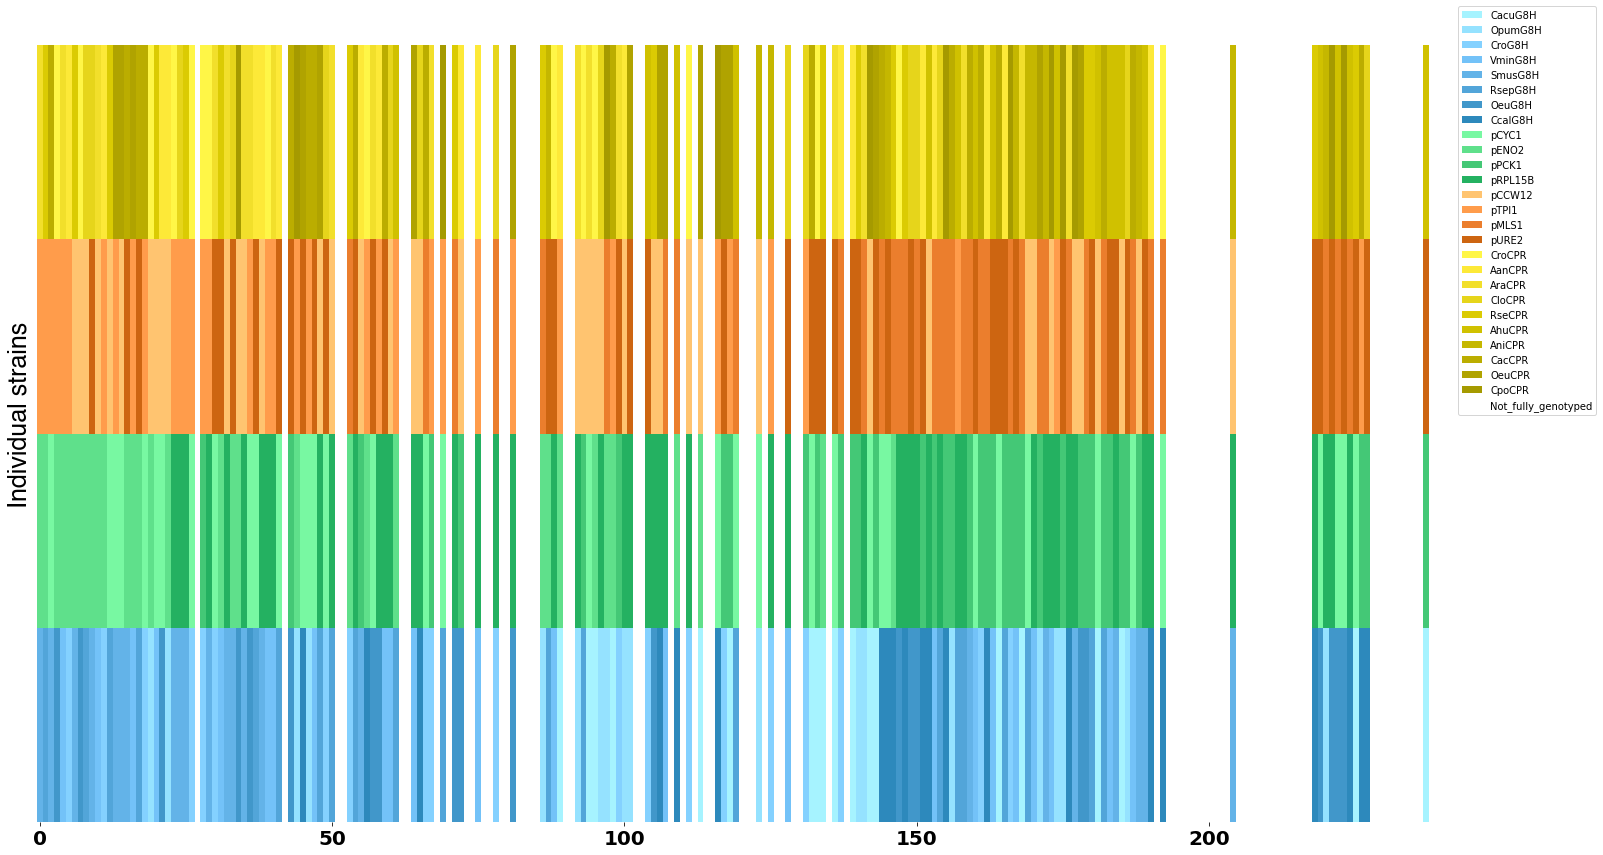

In [51]:
name = 'Carpet_plot_All_genotypes_from_the_first_library_WHITE'
carpet_barplot(cross_tab_prop, colorDict, save_pdf= True , path ='ConStrain_on_google_colab/data/10-plots/08_2_DESIGN_Targeted_library/'+name, xlabel ='' , ylabel = 'Individual strains' )

From this outcome, the parts encountered in the first 26 predictions from the RMSE were taken, resulting in 140 combinations and 35 transformations. 

# 4. ML discussion

**ML distribution:**
Quite objectively, we see that the most represented genes are
biologically speaking, the promoters are first the high-low, and then the constitutive high.


To choose which genes to proceed with, we say that we have to say from the top that we have 4 parts, each time we gpr down the list we add a part if a new one is represented. When we have the number of parts that together gives 180 (e.g. 4*3*3*5) we stop. these must be used. But some may have to be taken away if there are too many plates. then make the quadrature showing the distribution of parts in each part. This is to be discussed. it is interesting that we see

We follow the sampling theory where we say if there are 180 possible, then we will also sample 180. ie. if we have 20 plates, we take 9 from each, as there should be 9 possible combinations on a plate. We will fill the design space with these recomendations.


My round is optimal sampling -> in that we will sample the number of possible combinations there are.
first round was not optimal because we did not sample 1200 oga capacity. We will this time since we have it.
if we had more finds we would be more exploratory - in that we would then have more time to fill out the design space - because we still want to sample the number of possible ones. but in this case we will try to make it as "hurtgit/smart" as possible with the two rounds we have. Therefore, we try to find one of the best in the second round, based on the recommendations we have received in the first round.

the goal is to make one of the best in the shortest time. not the best, because then we might as well just do all of them. instead, we would like to spend our time finding the best one in several places in the pathway, which is why we prioritize making 2 iterations. the solution space is so large that we can't do all of them either.


If I want, I can do machine learning after the second iteration and look at the change in mae.

add image of promoters to understand them

I can see that the promoters are quite stable, we should only have two of each (which are the highly expressed ones). On the other hand, CPR is not very stable in that there are 7 different ones within the first 25 predictions. that is to say that they are probably not that important for how 'high' it is expressed - On the other hand, they are very important for f¨elstra G8H, and here they are probably a little more important.

**Conclusion**


We will be using ML to optimize our gene selection process by first focusing on the most highly represented genes and biologically classifying them as high-low or constitutive high promoters. We will then divide these genes into parts, with a goal of 180 total parts. However, if necessary, we may remove some to account for plate limitations. Our sampling strategy is based on the number of possible combinations, with the goal of achieving optimal sampling in the second round. Our ultimate goal is to quickly identify one of the best solutions within the large solution space by prioritizing 2 iterations and using ML for further analysis.